# numpy와 scipy를 이용한 신호측정
 **Matlab 사용할줄 몰라서/살 돈이 없어서 python 이용하는것도 맞음**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, fft, fftfreq
from scipy.signal import spectrogram

In [2]:
# 실습을 위한 fsk, qpsk raw 파일 불러오기, quantization이 int8(char)로 되어있기에 불러올때 dtype을 i1또는 np.int8로 해줘야함.
fsk = np.fromfile('fsk_2fsk_real_int8_fs48000_rs1200_len2s.raw', dtype='<i1') # <i1 == int8 type as little endian
qpsk = np.fromfile('qpsk_complex_int8_iq_interleaved_fs48000_rs6000_rrc035_sps8_len2s.raw', dtype='>i1')

# 정규화
fsk = np.float32(fsk) / 127.0 
qpsk = np.float32(qpsk) / 127.0  

## **Spectrogram을 이용한 fsk/qpsk 신호 확인**

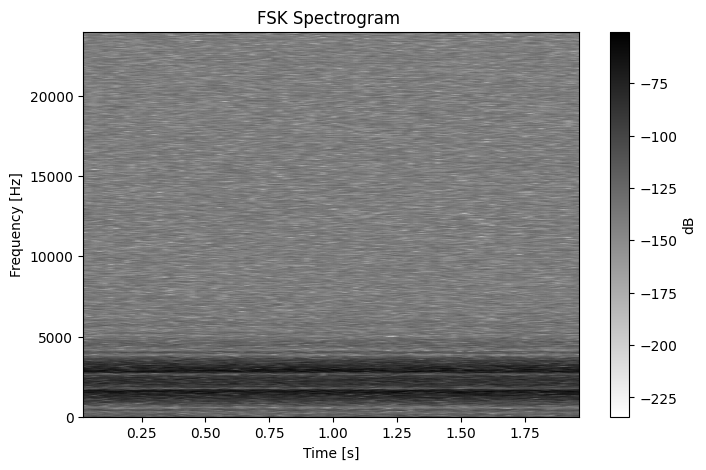

In [20]:
fs = 48000 # sampling Frequency

nperseg = 2**11 # FFT window length in spectrogram
noverlap = 2**10 # overlap sample count in spectrogram
######################################################################
# * nperseg를 길게잡으면 주파수 해상도가 올라가고 시간해상도가 낮아짐
# * noverlap을 겹칠수록 시간 해상도가 부드럽게 개선됨
######################################################################


f, t, S = spectrogram(fsk, fs=fs, nperseg=nperseg, noverlap=noverlap)
# f = 주파수 축
# t = 시간 축
# S = 스펙트로그램의 세기값

plt.figure(figsize=(8,5))
plt.pcolormesh(t, f, 20*np.log10(S+1e-12), shading='gouraud', cmap='binary')
# 2*10log(S)에 1e-12를 넣는 이유 = 로그에서 밑이 0이될수는 없으므로 S가 0일의 수학적 오류를 대비, 매우 작은 숫자를 대입해줌.

plt.ylim(0, 24000)  # sampling을 48000으로 했기에 ylim을 0-24000으로 주는게 맞지만 보기 편하게 0-6000으로 줌
plt.colorbar(label='dB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('FSK Spectrogram ')
plt.show()


#####  약 1700,2800hz대역에서 FSK 특유의 신호 특성이 육안으로 드러남.

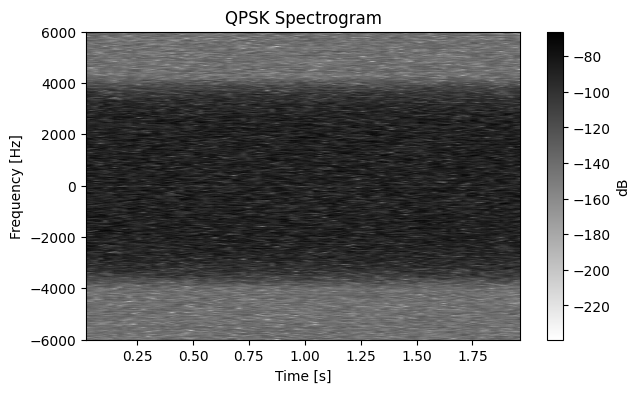

In [3]:
fs = 48000 # sampling Frequency

### 해당 raw파일은 complex(i + jq)로 입력된 파일으로 reshape후 복소수부분 할당
iq = qpsk.reshape(-1, 2)
z = iq[:,0] + 1j*iq[:,1]    # I + jQ


nperseg = 2**11 # FFT window length in spectrogram
noverlap = 2**10 # overlap sample count in spectrogram
f, t, S = spectrogram(z, fs=fs, nperseg=nperseg, noverlap=noverlap,
                      return_onesided=False) # input data에 complex가 있으니 return_onesided에 False 선언

# 4) 0 Hz를 가운데로 (보기 편하게 fftshift)
S = np.fft.fftshift(S, axes=0)
f = np.fft.fftshift(f)

# QPSK는 RRC(roll-off 0.35)라 이론 대역폭 B ≈ (1+α)/2 * Rs = 0.675 * 6000 ≈ 4050 Hz
# CFO=+120 Hz → 중심이 약 +120 Hz에 위치
plt.figure(figsize=(7,4))
plt.pcolormesh(t, f, 20*np.log10(S+1e-12), shading='gouraud', cmap='binary')
plt.ylim(-6000, 6000)
plt.xlabel('Time [s]'); plt.ylabel('Frequency [Hz]')
plt.title('QPSK Spectrogram')
plt.colorbar(label='dB')
plt.show()

##### IQ형식이라 FSK와 달리 추가적인 작업이 필요했음.

### ㅇ Time Domain 확인해보기

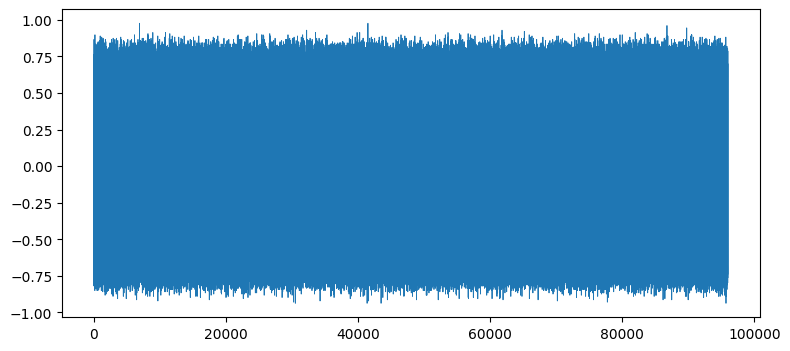

In [10]:
plt.figure(figsize=(9,4))
plt.plot(fsk, linewidth=0.6)

##### 정규화된 sample file을 단순히 plot에 그리면 사진이 이상하게 나온다. 이는 sampling을 안해서 그런거같은데 sampling을 한 후 다시 그려보자

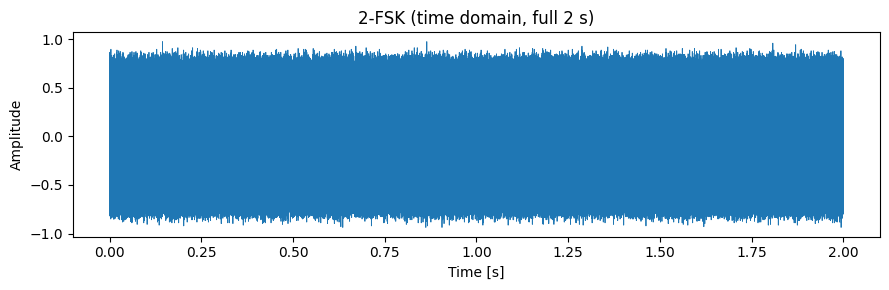

In [17]:
# fs = 48000 (앞 문단에 선언했기에 주석으로 처리)
# np.arange() <- 0부터 n까지 1단위로 배열을 나눠줌
t = np.arange(len(fsk)) / fs # 1초당 48,000개 샘플이므로 해당 식을 이용, graph x를 시간(초)로 바꿔줌.
# Out[]: array([0.00000000e+00, 2.08333333e-05, 4.16666667e-05, ...,
#       1.99993750e+00, 1.99995833e+00, 1.99997917e+00], shape=(96000,))

plt.figure(figsize=(9,3))
plt.plot(t, fsk, linewidth=0.6)
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.title("2-FSK (time domain, full 2 s)")
plt.tight_layout()
plt.show()

##### x axis를 초단위로 바꿔도 너무 굵게 나온다, 확대해서 눈으로 확인할수있게 해보자.

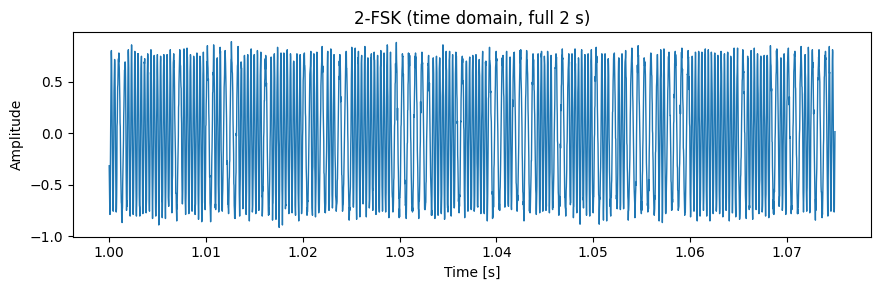

In [28]:
focusing = True

win_sec = 0.075   # 75 ms
t0 = 1         # 1 s부터 보기 (임의)

i0 = int(t0*fs)
i1 = i0 + int(win_sec*fs)

if focusing:
    plt.figure(figsize=(9,3))
    plt.plot(t[i0:i1], fsk[i0:i1], linewidth=1.0)
    plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
    plt.title("2-FSK (time domain, full 2 s)")
    plt.tight_layout()
    plt.show()


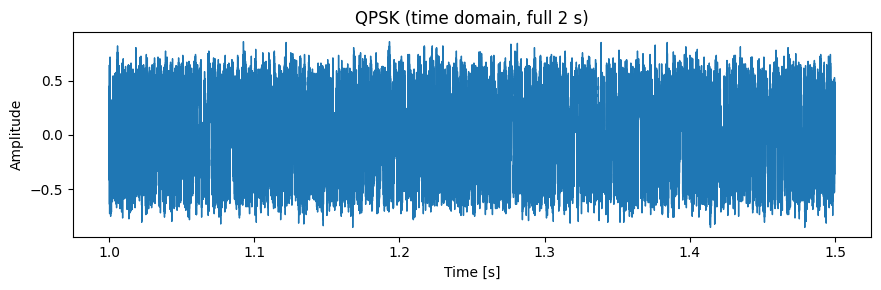

In [8]:
# qpsk도 한번 측정해보자

focusing = True
t = np.arange(len(qpsk)) / fs
win_sec = 0.5   # 75 ms
t0 = 1         # 1 s부터 보기 (임의)

i0 = int(t0*fs)
i1 = i0 + int(win_sec*fs)

if focusing:
    plt.figure(figsize=(9,3))
    plt.plot(t[i0:i1], qpsk[i0:i1], linewidth=1.0)
    plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
    plt.title("QPSK (time domain, full 2 s)")
    plt.tight_layout()
    plt.show()


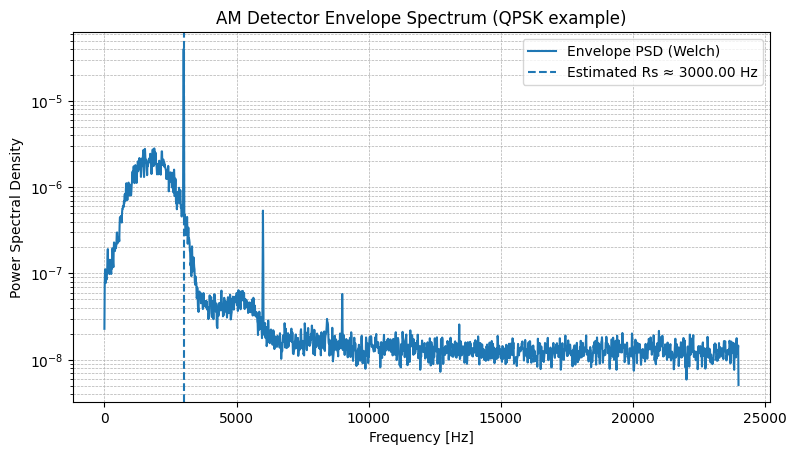

True Rs: 3000.00 Hz | Estimated Rs: 3000.00 Hz | sps=16


In [18]:
# QPSK simulation + AM-detector-based symbol-rate estimation with pyplot visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ---------- Utilities ----------
def rrc_filter(beta, span, sps):
    """
    Root-Raised-Cosine (RRC) filter taps.
    beta: roll-off (0~1)
    span: filter length in symbols (e.g., 8~12)
    sps: samples per symbol (oversampling factor)
    """
    N = span * sps
    t = (np.arange(-N/2, N/2 + 1) / sps).astype(float)  # in symbol times
    h = np.zeros_like(t, dtype=float)
    for i, ti in enumerate(t):
        if np.isclose(ti, 0.0):
            h[i] = 1.0 - beta + 4*beta/np.pi
        elif beta != 0 and np.isclose(abs(ti), 1/(4*beta)):
            # l'Hospital for singularity at t = ±T/(4β)
            h[i] = (beta/np.sqrt(2)) * (
                ((1 + 2/np.pi) * np.sin(np.pi/(4*beta))) +
                ((1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
            )
        else:
            num = np.sin(np.pi*ti*(1 - beta)) + 4*beta*ti*np.cos(np.pi*ti*(1 + beta))
            den = np.pi*ti*(1 - (4*beta*ti)**2)
            h[i] = num / den
    # Normalize to unit energy
    h /= np.sqrt(np.sum(h**2))
    return h

def qpsk_symbols(Nsym):
    bits = np.random.randint(0, 2, size=2*Nsym)
    # Gray mapping: 00->(1+1j), 01->(-1+1j), 11->(-1-1j), 10->(1-1j)
    b0 = bits[0::2]
    b1 = bits[1::2]
    I = 1 - 2*b0
    Q = 1 - 2*b1
    # Rotate by 45° so points at π/4, 3π/4, 5π/4, 7π/4 (optional, common)
    const = (I + 1j*Q) / np.sqrt(2)
    return const

def upsample(symbols, sps):
    up = np.zeros(len(symbols)*sps, dtype=complex)
    up[::sps] = symbols
    return up

def am_detector_symbol_rate(x, fs):
    env = np.abs(x)
    env = env - np.mean(env)
    f, Pxx = welch(env, fs=fs, nperseg=4096)
    idx = np.argmax(Pxx[1:]) + 1  # skip DC
    Rs_est = f[idx]
    return Rs_est, f, Pxx

# ---------- Parameters ----------
fs = 48000.0                  # sampling rate [Hz]
Rs_true = 3000.0              # symbol rate [Hz]
sps = int(round(fs / Rs_true))
Rs_true = fs / sps            # ensure integer sps compatibility
Nsym = 4000                   # number of symbols
beta = 0.35                   # RRC roll-off
span = 10                     # RRC length in symbols
snr_db = 20                   # AWGN SNR in dB

# ---------- Transmitter ----------
syms = qpsk_symbols(Nsym)
x_up = upsample(syms, sps)
h = rrc_filter(beta, span, sps)
x_bb = np.convolve(x_up, h, mode='same')

# ---------- AWGN ----------
sig_power = np.mean(np.abs(x_bb)**2)
noise_power = sig_power / (10**(snr_db/10))
noise = np.sqrt(noise_power/2) * (np.random.randn(*x_bb.shape) + 1j*np.random.randn(*x_bb.shape))
x_rx = x_bb + noise

# ---------- AM-detector-based Rs estimation ----------
Rs_est, f, Pxx = am_detector_symbol_rate(x_rx, fs)

# ---------- Visualizations ----------
# 1) PSD of the envelope with estimated Rs marker
plt.figure(figsize=(9, 4.8))
plt.semilogy(f, Pxx, label="Envelope PSD (Welch)")
plt.axvline(Rs_est, linestyle='--', label=f"Estimated Rs ≈ {Rs_est:.2f} Hz")
plt.title("AM Detector Envelope Spectrum (QPSK example)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

print(f"True Rs: {Rs_true:.2f} Hz | Estimated Rs: {Rs_est:.2f} Hz | sps={sps}")


#####  envelope 검사 후 Welch PSD로 스펙트럼을 구함. 이를통해 얻은 peak를 기반으로 전송속도를 측정
##### 코드 구현난도가 있다보니 생성형 ai를 이용함

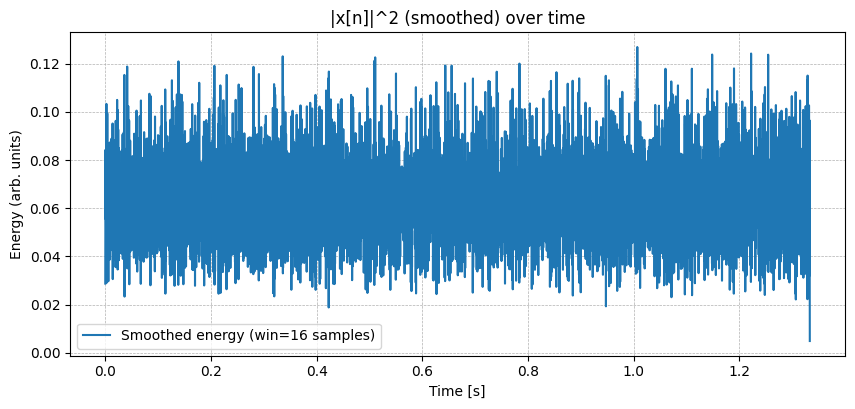

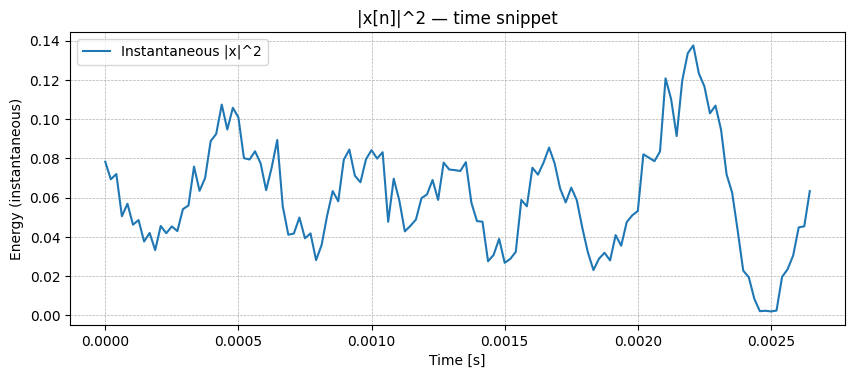

In [19]:
# Plot energy (|x|^2) of the current simulated signal.
# Assumes x_rx and fs exist from the previous cells.

import numpy as np
import matplotlib.pyplot as plt

# Safety: if x_rx/fs are not defined, create a tiny fallback demo
try:
    x_rx
    fs
except NameError:
    fs = 48000.0
    N = 48000
    t = np.arange(N)/fs
    x_rx = np.exp(1j*2*np.pi*1000*t) + 0.1*(np.random.randn(N)+1j*np.random.randn(N))

# Instantaneous energy
energy = np.abs(x_rx)**2
t = np.arange(len(x_rx))/fs

# Smoothed energy over ~1 symbol (if sps is available)
try:
    sps
    win = max(1, int(sps))
except NameError:
    win = int(0.001 * fs)  # fallback: 1 ms window
    sps = None

kernel = np.ones(win)/win
energy_smooth = np.convolve(energy, kernel, mode='same')

# Plot 1: Smoothed energy over the full record
plt.figure(figsize=(10, 4.2))
plt.plot(t, energy_smooth, label=f"Smoothed energy (win={win} samples)")
plt.title("|x[n]|^2 (smoothed) over time")
plt.xlabel("Time [s]")
plt.ylabel("Energy (arb. units)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot 2: Instantaneous energy — short snippet (~8 symbols if sps known, else 10 ms)
if sps is not None:
    N_show = 8 * sps
else:
    N_show = int(0.010 * fs)  # 10 ms
N_show = min(N_show, len(energy))

plt.figure(figsize=(10, 3.8))
plt.plot(t[:N_show], energy[:N_show], label="Instantaneous |x|^2")
plt.title("|x[n]|^2 — time snippet")
plt.xlabel("Time [s]")
plt.ylabel("Energy (instantaneous)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


#### 신호의 시간별 energy값 검출

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy import signal
from scipy.signal import hilbert

# 1) 업샘플링: resample_poly만 사용
def upsample_resample_poly(x: np.ndarray, fs_in: float, fs_out: float,
                           max_den: int = 1000, window=('kaiser', 8.6)) -> tuple[np.ndarray, float]:
    """
    Real 1D 신호 x를 polyphase 보간으로 샘플레이트 변경
    - fs_in -> fs_out
    - max_den: 기약분수 분모 상한(계산량 제어)
    - window: FIR LPF 모양(기본 Kaiser 8.6 ≈ ~60 dB)
    반환: (y, fs_out)
    """
    x = np.asarray(x, dtype=np.float32)
    if fs_in == fs_out:
        return x, fs_in
    ratio = Fraction(fs_out, fs_in).limit_denominator(max_den)
    up, dn = ratio.numerator, ratio.denominator
    y = signal.resample_poly(x, up=up, down=dn, window=window).astype(np.float32)
    return y, fs_out


# 2) n-제곱 스펙트로그램 (실수 신호 -> analytic -> x^n)
def nth_power_spectrogram_real(x: np.ndarray, fs: float, n: int = 4,
                               nperseg: int = 2048, overlap: float = 0.75,
                               to_db: bool = True, use_hilbert: bool = True):
    """
    실수 신호 x에 대해 n-th 파워 스펙트로그램 계산
    - use_hilbert=True: analytic 변환 후 제곱(권장)
    반환: (f, t, S)  # S는 dB 또는 선형
    """
    x = np.asarray(x, dtype=np.float32)
    if use_hilbert:
        xa = hilbert(x).astype(np.complex64)   # analytic (단측대역)
    else:
        # 비권장: 실수 그대로 n제곱 -> 좌우대역 섞임 가능
        xa = x.astype(np.complex64)

    xn = xa ** n

    noverlap = int(nperseg * overlap)
    f, t, S = signal.spectrogram(
        xn, fs=fs, nperseg=nperseg, noverlap=noverlap,
        nfft=nperseg, return_onesided=False, detrend=False,
        scaling="density", mode="psd"
    )
    # 0 Hz 중심으로 정렬
    f = np.fft.fftshift(f)
    S = np.fft.fftshift(S, axes=0)

    if to_db:
        S = 10.0 * np.log10(S + 1e-12)

    return f, t, S


def show_spectrogram(f, t, S, title="n-th Power Spectrogram (0 Hz centered)", zlabel="dB"):
    plt.figure()
    plt.pcolormesh(f, t, S, shading="gouraud")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Time [s]")
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(zlabel)
    plt.tight_layout()
    plt.show()


In [ ]:
# 예시: 실수 baseband + 약간의 캐리어(AM 느낌)
fs_in = 8000
t = np.arange(0, 1.5, 1/fs_in, dtype=np.float32)

# 실수 톤 2개 + 약한 진폭 변조
x = 0.6*np.sin(2*np.pi*600*t) + 0.4*np.sin(2*np.pi*900*t)
x *= 1.0 + 0.3*np.sin(2*np.pi*5*t)  # 천천한 AM

# 1) 업샘플: 8 kHz -> 32 kHz
fs_out = 32000
y, _ = upsample_resample_poly(x, fs_in, fs_out)

# 2) n-제곱 스펙트로그램 (n=4, analytic 사용)
f, tt, S = nth_power_spectrogram_real(y, fs_out, n=4, nperseg=2048, overlap=0.75, to_db=True, use_hilbert=True)
show_spectrogram(f, tt, S, title="4th-Power Spectrogram (real signal, upsampled)", zlabel="dB")


TypeError: Dimensions of C (2048, 90) are incompatible with X (2048) and/or Y (90); see help(pcolormesh)